In [1]:
# VW ID.4 + Solar Array Analysis
# Specific to: 4250 rue Belanger, Montreal, Quebec
# 
# Requirements:
#     pip install hydroq-api pandas matplotlib python-dotenv numpy scipy

import warnings
warnings.filterwarnings('ignore')

from hydroq_api import HydroQuebec
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
from dotenv import load_dotenv
from scipy import stats

In [2]:


load_dotenv()

USERNAME = os.getenv('HYDRO_QUEBEC_USERNAME')
PASSWORD = os.getenv('HYDRO_QUEBEC_PASSWORD')

if not USERNAME or not PASSWORD:
    raise ValueError("Credentials not found!")

print("="*80)
print(" VW ID.4 + SOLAR ANALYSIS")
print(" Location: 4250 rue Bélanger, Montreal (Rosemont)")
print(" Scenario: $10,000 Solar Array + 20,000 km/year driving")
print("="*80)

# ## CONFIGURATION

# Your specific parameters
SOLAR_BUDGET_CAD = 10000
ANNUAL_DRIVING_KM = 20000
OWNERSHIP_YEARS = 10
ADDRESS = "4250 rue Bélanger, Montreal, QC"

# VW ID.4 specifications (82 kWh battery, 77 kWh usable)
VW_ID4 = {
    'battery_capacity_kwh': 82,
    'usable_capacity_kwh': 77,
    'efficiency_kwh_per_100km': 18.5,  # EPA combined for 2024 ID.4 Pro
    'range_km': 416,  # EPA estimate
    'charging_efficiency': 0.90,  # 10% loss during charging
}

# Montreal/Rosemont solar potential
# Latitude: ~45.55°N, Rosemont is inner Montreal
MONTREAL_SOLAR = {
    'annual_kwh_per_kw': 1180,  # Slightly lower than southern Quebec (more urban)
    'winter_factor': 0.30,  # Dec-Feb (30% of annual)
    'spring_factor': 0.25,  # Mar-May (25%)
    'summer_factor': 0.30,  # Jun-Aug (30%)
    'fall_factor': 0.15,  # Sep-Nov (15%)
    'system_efficiency': 0.85,  # Panel degradation, inverter losses, shading
    'optimal_tilt': 45,  # Degrees (equal to latitude)
}

# Quebec solar costs and incentives (2025)
SOLAR_COSTS = {
    'cost_per_watt': 2.90,  # $2.60-$3.27/W range, using average
    'hq_incentive_per_kw': 1000,  # $1000/kW
    'max_incentive_percent': 0.40,  # Max 40% of total
}

# Hydro-Québec rates (2025)
RATES = {
    'tier1_price': 0.0673,  # $/kWh (first 40 kWh/day)
    'tier2_price': 0.1038,  # $/kWh (above 40 kWh/day)
    'system_access_daily': 0.004978,  # $/day
}

# Gasoline comparison (for context)
GAS_COMPARISON = {
    'price_per_liter': 1.65,  # CAD, approximate Montreal 2025
    'avg_fuel_economy_l_per_100km': 8.5,  # Comparable gas SUV
}

print("\n✓ Configuration loaded")

 VW ID.4 + SOLAR ANALYSIS
 Location: 4250 rue Bélanger, Montreal (Rosemont)
 Scenario: $10,000 Solar Array + 20,000 km/year driving

✓ Configuration loaded


In [3]:

# ## 1. DETERMINE SOLAR SYSTEM SIZE

# Calculate maximum system size for $10,000 budget
gross_cost_per_kw = SOLAR_COSTS['cost_per_watt'] * 1000

# With incentive: Net cost = Gross - min(Gross × 40%, $1000/kW)
# Solve for system size
def calculate_net_cost(kw_size):
    gross = kw_size * gross_cost_per_kw
    incentive = min(gross * SOLAR_COSTS['max_incentive_percent'], 
                   kw_size * SOLAR_COSTS['hq_incentive_per_kw'])
    return gross - incentive

# Find system size for $10,000 budget
max_kw_for_budget = 0
for kw in np.arange(1.0, 20.0, 0.1):
    if calculate_net_cost(kw) <= SOLAR_BUDGET_CAD:
        max_kw_for_budget = kw
    else:
        break

solar_size_kw = max_kw_for_budget
gross_cost = solar_size_kw * gross_cost_per_kw
incentive = min(gross_cost * SOLAR_COSTS['max_incentive_percent'],
               solar_size_kw * SOLAR_COSTS['hq_incentive_per_kw'])
net_cost = gross_cost - incentive

# Annual solar production
annual_solar_kwh = (solar_size_kw * 
                   MONTREAL_SOLAR['annual_kwh_per_kw'] * 
                   MONTREAL_SOLAR['system_efficiency'])

print("\n" + "="*80)
print("SOLAR SYSTEM SIZING FOR $10,000 BUDGET")
print("="*80)
print(f"Maximum system size: {solar_size_kw:.2f} kW")
print(f"Gross cost: ${gross_cost:,.0f}")
print(f"Hydro-Québec incentive: -${incentive:,.0f}")
print(f"Your net cost: ${net_cost:,.0f}")
print(f"\nAnnual production: {annual_solar_kwh:,.0f} kWh/year")
print(f"Daily average: {annual_solar_kwh/365:.1f} kWh/day")

# Monthly production
monthly_production = {
    'Winter (Dec-Feb)': annual_solar_kwh * MONTREAL_SOLAR['winter_factor'] / 3,
    'Spring (Mar-May)': annual_solar_kwh * MONTREAL_SOLAR['spring_factor'] / 3,
    'Summer (Jun-Aug)': annual_solar_kwh * MONTREAL_SOLAR['summer_factor'] / 3,
    'Fall (Sep-Nov)': annual_solar_kwh * MONTREAL_SOLAR['fall_factor'] / 3,
}

print("\nMonthly average production:")
for season, kwh in monthly_production.items():
    print(f"  {season}: {kwh:.0f} kWh/month ({kwh/30:.1f} kWh/day)")


SOLAR SYSTEM SIZING FOR $10,000 BUDGET
Maximum system size: 5.20 kW
Gross cost: $15,080
Hydro-Québec incentive: -$5,200
Your net cost: $9,880

Annual production: 5,216 kWh/year
Daily average: 14.3 kWh/day

Monthly average production:
  Winter (Dec-Feb): 522 kWh/month (17.4 kWh/day)
  Spring (Mar-May): 435 kWh/month (14.5 kWh/day)
  Summer (Jun-Aug): 522 kWh/month (17.4 kWh/day)
  Fall (Sep-Nov): 261 kWh/month (8.7 kWh/day)


In [4]:


# ## 2. CALCULATE VW ID.4 CHARGING NEEDS

annual_ev_consumption_kwh = (ANNUAL_DRIVING_KM / 100 * 
                             VW_ID4['efficiency_kwh_per_100km'] /
                             VW_ID4['charging_efficiency'])

daily_ev_consumption = annual_ev_consumption_kwh / 365
monthly_ev_consumption = annual_ev_consumption_kwh / 12

print("\n" + "="*80)
print("VW ID.4 CHARGING REQUIREMENTS")
print("="*80)
print(f"Annual driving: {ANNUAL_DRIVING_KM:,} km")
print(f"Vehicle efficiency: {VW_ID4['efficiency_kwh_per_100km']} kWh/100km")
print(f"Charging efficiency: {VW_ID4['charging_efficiency']*100:.0f}%")
print(f"\nAnnual charging needed: {annual_ev_consumption_kwh:,.0f} kWh")
print(f"Daily average: {daily_ev_consumption:.1f} kWh")
print(f"Monthly average: {monthly_ev_consumption:.0f} kWh")

# Calculate % of solar dedicated to EV
ev_solar_coverage = min(1.0, annual_ev_consumption_kwh / annual_solar_kwh)
solar_for_ev_kwh = annual_ev_consumption_kwh * ev_solar_coverage
solar_for_home_kwh = annual_solar_kwh - solar_for_ev_kwh

print(f"\nSolar allocation:")
print(f"  EV charging: {solar_for_ev_kwh:,.0f} kWh/year ({ev_solar_coverage*100:.1f}%)")
print(f"  Available for home: {solar_for_home_kwh:,.0f} kWh/year ({(1-ev_solar_coverage)*100:.1f}%)")



VW ID.4 CHARGING REQUIREMENTS
Annual driving: 20,000 km
Vehicle efficiency: 18.5 kWh/100km
Charging efficiency: 90%

Annual charging needed: 4,111 kWh
Daily average: 11.3 kWh
Monthly average: 343 kWh

Solar allocation:
  EV charging: 3,241 kWh/year (78.8%)
  Available for home: 1,975 kWh/year (21.2%)


In [5]:


# ## 3. CALCULATE SAVINGS FROM SOLAR EV CHARGING

# Cost if charging from grid
grid_tier1_daily = 40
annual_days = 365

# Assume EV charging spreads across tier 1 and tier 2
# Most homes hit tier 2, so we'll use blended rate
avg_rate = (RATES['tier1_price'] + RATES['tier2_price']) / 2

cost_grid_charging = annual_ev_consumption_kwh * avg_rate
cost_solar_charging = 0  # Free from solar!
annual_savings_ev = cost_grid_charging - cost_solar_charging

# 10-year savings
total_savings_10yr = annual_savings_ev * OWNERSHIP_YEARS

# Gasoline comparison
gas_liters_saved = ANNUAL_DRIVING_KM / 100 * GAS_COMPARISON['avg_fuel_economy_l_per_100km']
gas_cost_saved = gas_liters_saved * GAS_COMPARISON['price_per_liter']

print("\n" + "="*80)
print("SAVINGS ANALYSIS - EV CHARGING WITH SOLAR")
print("="*80)
print(f"\n📊 ANNUAL SAVINGS:")
print(f"  Cost to charge from grid: ${cost_grid_charging:.0f}/year")
print(f"  Cost to charge from solar: $0/year")
print(f"  → Annual savings: ${annual_savings_ev:.0f}/year")

print(f"\n💰 10-YEAR SAVINGS:")
print(f"  Total savings over {OWNERSHIP_YEARS} years: ${total_savings_10yr:,.0f}")
print(f"  Solar system cost: ${net_cost:,.0f}")
print(f"  → Net benefit: ${total_savings_10yr - net_cost:,.0f}")
print(f"  → Payback period: {net_cost / annual_savings_ev:.1f} years")

print(f"\n⛽ VS GASOLINE VEHICLE:")
print(f"  Gas consumed by equivalent SUV: {gas_liters_saved:,.0f} L/year")
print(f"  Gas cost at ${GAS_COMPARISON['price_per_liter']:.2f}/L: ${gas_cost_saved:,.0f}/year")
print(f"  Electricity cost (from solar): $0/year")
print(f"  → Annual savings vs gas: ${gas_cost_saved:.0f}/year")
print(f"  → 10-year savings vs gas: ${gas_cost_saved * OWNERSHIP_YEARS:,.0f}")



SAVINGS ANALYSIS - EV CHARGING WITH SOLAR

📊 ANNUAL SAVINGS:
  Cost to charge from grid: $352/year
  Cost to charge from solar: $0/year
  → Annual savings: $352/year

💰 10-YEAR SAVINGS:
  Total savings over 10 years: $3,517
  Solar system cost: $9,880
  → Net benefit: $-6,363
  → Payback period: 28.1 years

⛽ VS GASOLINE VEHICLE:
  Gas consumed by equivalent SUV: 1,700 L/year
  Gas cost at $1.65/L: $2,805/year
  Electricity cost (from solar): $0/year
  → Annual savings vs gas: $2805/year
  → 10-year savings vs gas: $28,050


In [6]:

# ## 4. RETRIEVE YOUR HOME CONSUMPTION DATA

print("\n" + "="*80)
print("ANALYZING YOUR HOME CONSUMPTION")
print("="*80)

print("\nLogging in to Hydro-Québec...")
client = HydroQuebec(USERNAME, PASSWORD)
client.login()
print("✓ Connected")

end_date = datetime.now()
start_date = end_date - timedelta(days=365)

print(f"\nFetching YOUR data from {start_date.date()} to {end_date.date()}...")
daily_data = client.get_daily_usage(
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d')
)

if not daily_data or not daily_data.get('success'):
    raise Exception("Could not retrieve data")

results = daily_data.get('results', [])
consumption_list = []
for entry in results:
    current = entry.get('courant', {})
    consumption_list.append({
        'date': current.get('dateJourConso'),
        'consumption_kwh': current.get('consoTotalQuot', 0),
        'avg_temperature': current.get('tempMoyenneQuot'),
    })

df = pd.DataFrame(consumption_list)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')
df = df.dropna(subset=['avg_temperature'])

print(f"✓ Retrieved {len(df)} days of YOUR consumption data")

# Analyze critical loads from your data
mild_temp_mask = (df['avg_temperature'] >= 15) & (df['avg_temperature'] <= 20)
baseline_consumption = df.loc[mild_temp_mask, 'consumption_kwh'].median()

heating_threshold = 18
df['heating_estimate'] = 0.0
heating_mask = df['avg_temperature'] < heating_threshold

if heating_mask.sum() > 0:
    heating_data = df[heating_mask].copy()
    z_scores = np.abs(stats.zscore(heating_data['consumption_kwh']))
    heating_data_clean = heating_data[z_scores < 3]
    
    if len(heating_data_clean) > 10:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            heating_data_clean['avg_temperature'],
            heating_data_clean['consumption_kwh']
        )
        df.loc[heating_mask, 'heating_estimate'] = np.maximum(
            0,
            df.loc[heating_mask, 'consumption_kwh'] - baseline_consumption
        )

# Calculate critical loads
CRITICAL_BASE_KWH = 5.8  # Fridge, freezer, lights, internet, sump pump

winter_months = [12, 1, 2, 3]
avg_winter_heating = df[df.index.month.isin(winter_months)]['heating_estimate'].mean()
critical_winter_kwh = CRITICAL_BASE_KWH + avg_winter_heating
critical_summer_kwh = CRITICAL_BASE_KWH

print(f"\nYour home profile:")
print(f"  Baseline consumption: {baseline_consumption:.1f} kWh/day")
print(f"  Winter heating (avg): {avg_winter_heating:.1f} kWh/day")
print(f"  Critical loads (winter): {critical_winter_kwh:.1f} kWh/day")
print(f"  Critical loads (summer): {critical_summer_kwh:.1f} kWh/day")



ANALYZING YOUR HOME CONSUMPTION

Logging in to Hydro-Québec...
✓ Connected

Fetching YOUR data from 2025-01-02 to 2026-01-02...
✓ Retrieved 365 days of YOUR consumption data

Your home profile:
  Baseline consumption: 25.7 kWh/day
  Winter heating (avg): 142.5 kWh/day
  Critical loads (winter): 148.3 kWh/day
  Critical loads (summer): 5.8 kWh/day


In [7]:
# ## 5. SOLAR BACKUP CAPABILITY FOR CRITICAL LOADS

print("\n" + "="*80)
print("CRITICAL LOADS BACKUP WITH SOLAR + ID.4 BATTERY")
print("="*80)

# Scenario: Grid outage, using solar + ID.4 battery
# Assume you reserve 20% of ID.4 battery for emergency driving
id4_backup_capacity = VW_ID4['usable_capacity_kwh'] * 0.80  # 80% for home

print(f"\nBackup resources:")
print(f"  VW ID.4 battery (80% available): {id4_backup_capacity:.1f} kWh")
print(f"  Daily solar production (avg): {annual_solar_kwh/365:.1f} kWh")
print(f"  Winter daily solar: {annual_solar_kwh * MONTREAL_SOLAR['winter_factor'] / 90:.1f} kWh")
print(f"  Summer daily solar: {annual_solar_kwh * MONTREAL_SOLAR['summer_factor'] / 90:.1f} kWh")

# Calculate days of backup
winter_daily_solar = annual_solar_kwh * MONTREAL_SOLAR['winter_factor'] / 90
summer_daily_solar = annual_solar_kwh * MONTREAL_SOLAR['summer_factor'] / 90

# Winter scenario (worst case)
winter_net_daily = winter_daily_solar - critical_winter_kwh
if winter_net_daily >= 0:
    # Solar covers daily needs, battery unused
    winter_days_backup = float('inf')
    winter_note = "indefinitely (solar covers daily needs)"
else:
    # Drawing from battery each day
    winter_days_backup = id4_backup_capacity / abs(winter_net_daily)
    winter_note = f"{winter_days_backup:.1f} days"

# Summer scenario (best case)
summer_net_daily = summer_daily_solar - critical_summer_kwh
if summer_net_daily >= 0:
    summer_days_backup = float('inf')
    summer_note = "indefinitely (solar covers daily needs + charging surplus)"
else:
    summer_days_backup = id4_backup_capacity / abs(summer_net_daily)
    summer_note = f"{summer_days_backup:.1f} days"

print(f"\n⚡ BACKUP DURATION (Grid Outage):")
print(f"\nWINTER (December-February):")
print(f"  Daily solar: {winter_daily_solar:.1f} kWh")
print(f"  Critical loads: {critical_winter_kwh:.1f} kWh")
print(f"  Net daily: {winter_net_daily:+.1f} kWh")
print(f"  → Backup duration: {winter_note}")

print(f"\nSUMMER (June-August):")
print(f"  Daily solar: {summer_daily_solar:.1f} kWh")
print(f"  Critical loads: {critical_summer_kwh:.1f} kWh")
print(f"  Net daily: {summer_net_daily:+.1f} kWh")
print(f"  → Backup duration: {summer_note}")

# No solar scenario (nighttime outage)
battery_only_winter = id4_backup_capacity / critical_winter_kwh
battery_only_summer = id4_backup_capacity / critical_summer_kwh

print(f"\nBATTERY ONLY (No solar/nighttime):")
print(f"  Winter: {battery_only_winter:.1f} days")
print(f"  Summer: {battery_only_summer:.1f} days")


CRITICAL LOADS BACKUP WITH SOLAR + ID.4 BATTERY

Backup resources:
  VW ID.4 battery (80% available): 61.6 kWh
  Daily solar production (avg): 14.3 kWh
  Winter daily solar: 17.4 kWh
  Summer daily solar: 17.4 kWh

⚡ BACKUP DURATION (Grid Outage):

WINTER (December-February):
  Daily solar: 17.4 kWh
  Critical loads: 148.3 kWh
  Net daily: -130.9 kWh
  → Backup duration: 0.5 days

SUMMER (June-August):
  Daily solar: 17.4 kWh
  Critical loads: 5.8 kWh
  Net daily: +11.6 kWh
  → Backup duration: indefinitely (solar covers daily needs + charging surplus)

BATTERY ONLY (No solar/nighttime):
  Winter: 0.4 days
  Summer: 10.6 days



✓ Chart saved to: vw_id4_solar_analysis.png


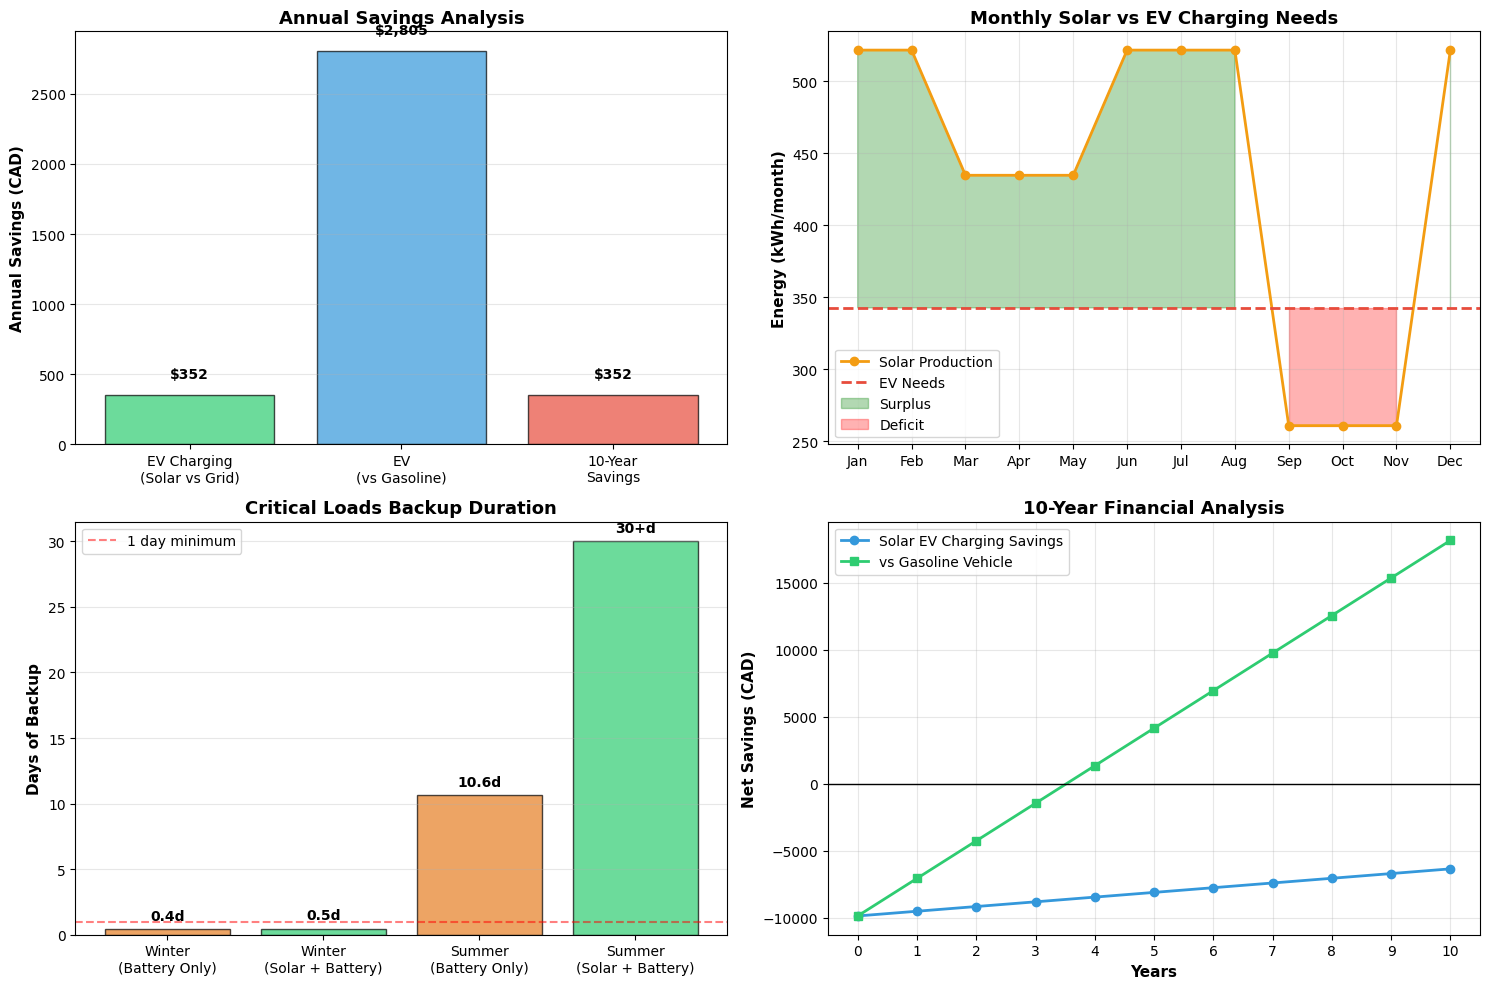


FINAL SUMMARY - VW ID.4 + $10,000 SOLAR (4250 Bélanger)

🏠 YOUR SETUP:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Location: 4250 rue Bélanger, Montreal (Rosemont–La Petite-Patrie)
Solar system: 5.20 kW ($9,880 after incentive)
Annual production: 5,216 kWh
Vehicle: VW ID.4 (82 kWh battery, 77 kWh usable)
Annual driving: 20,000 km

💰 SAVINGS OVER 10 YEARS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Annual EV charging savings: $352/year
10-year total savings: $3,517
Solar system cost: $9,880
NET 10-year benefit: $-6,363
Payback period: 28.1 years

Compared to gasoline SUV:
  Annual fuel savings: $2,805/year
  10-year fuel savings: $28,050
  
⚡ BACKUP POWER CAPABILITY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Critical loads: 148.3 kWh/day (winter), 5.8 kWh/day (summer)
ID.4 battery for home: 61.6 kWh (80% of battery)

WINTER backup (worst case):
  • Battery only: 0.4 days
  • Solar + battery: 0.5 days
  • Daily deficit: 130.9 kWh (solar insufficient i

In [8]:

# ## 6. VISUALIZATION

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Annual savings breakdown
categories = ['EV Charging\n(Solar vs Grid)', 'EV\n(vs Gasoline)', '10-Year\nSavings']
savings = [annual_savings_ev, gas_cost_saved, total_savings_10yr/10]
colors = ['#2ecc71', '#3498db', '#e74c3c']

ax1.bar(categories, savings, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Annual Savings (CAD)', fontsize=11, fontweight='bold')
ax1.set_title('Annual Savings Analysis', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(savings):
    ax1.text(i, v + 100, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 2. Monthly solar production vs EV needs
months = list(range(1, 13))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonal_production = []
for m in months:
    if m in [12, 1, 2]:
        seasonal_production.append(annual_solar_kwh * MONTREAL_SOLAR['winter_factor'] / 3)
    elif m in [3, 4, 5]:
        seasonal_production.append(annual_solar_kwh * MONTREAL_SOLAR['spring_factor'] / 3)
    elif m in [6, 7, 8]:
        seasonal_production.append(annual_solar_kwh * MONTREAL_SOLAR['summer_factor'] / 3)
    else:
        seasonal_production.append(annual_solar_kwh * MONTREAL_SOLAR['fall_factor'] / 3)

ax2.plot(months, seasonal_production, marker='o', linewidth=2, 
         label='Solar Production', color='#f39c12')
ax2.axhline(monthly_ev_consumption, color='#e74c3c', linestyle='--', 
            linewidth=2, label='EV Needs')
ax2.fill_between(months, seasonal_production, monthly_ev_consumption, 
                  where=np.array(seasonal_production) >= monthly_ev_consumption,
                  alpha=0.3, color='green', label='Surplus')
ax2.fill_between(months, seasonal_production, monthly_ev_consumption,
                  where=np.array(seasonal_production) < monthly_ev_consumption,
                  alpha=0.3, color='red', label='Deficit')
ax2.set_xticks(months)
ax2.set_xticklabels(month_names)
ax2.set_ylabel('Energy (kWh/month)', fontsize=11, fontweight='bold')
ax2.set_title('Monthly Solar vs EV Charging Needs', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Backup capability
scenarios = ['Winter\n(Battery Only)', 'Winter\n(Solar + Battery)', 
             'Summer\n(Battery Only)', 'Summer\n(Solar + Battery)']
days = [battery_only_winter, winter_days_backup if winter_days_backup != float('inf') else 30,
        battery_only_summer, summer_days_backup if summer_days_backup != float('inf') else 30]
bar_colors = ['#e67e22', '#2ecc71', '#e67e22', '#2ecc71']

bars = ax3.bar(scenarios, days, color=bar_colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Days of Backup', fontsize=11, fontweight='bold')
ax3.set_title('Critical Loads Backup Duration', fontsize=13, fontweight='bold')
ax3.axhline(1, color='red', linestyle='--', alpha=0.5, label='1 day minimum')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend()
for i, (bar, day) in enumerate(zip(bars, days)):
    label = f'{day:.1f}d' if day < 30 else '30+d'
    ax3.text(bar.get_x() + bar.get_width()/2, day + 0.5, label,
             ha='center', va='bottom', fontweight='bold')

# 4. Payback timeline
years = list(range(0, 11))
cumulative_savings = [annual_savings_ev * y - net_cost for y in years]
cumulative_gas_savings = [(annual_savings_ev + gas_cost_saved - cost_grid_charging) * y - net_cost 
                          for y in years]

ax4.plot(years, cumulative_savings, marker='o', linewidth=2, 
         label='Solar EV Charging Savings', color='#3498db')
ax4.plot(years, cumulative_gas_savings, marker='s', linewidth=2,
         label='vs Gasoline Vehicle', color='#2ecc71')
ax4.axhline(0, color='black', linestyle='-', linewidth=1)
ax4.fill_between(years, 0, cumulative_savings, where=np.array(cumulative_savings) > 0,
                  alpha=0.2, color='green')
ax4.set_xlabel('Years', fontsize=11, fontweight='bold')
ax4.set_ylabel('Net Savings (CAD)', fontsize=11, fontweight='bold')
ax4.set_title('10-Year Financial Analysis', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xticks(years)

plt.tight_layout()
plt.savefig('vw_id4_solar_analysis.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Chart saved to: vw_id4_solar_analysis.png")
plt.show()

# ## 7. FINAL SUMMARY

print("\n" + "="*80)
print("FINAL SUMMARY - VW ID.4 + $10,000 SOLAR (4250 Bélanger)")
print("="*80)

print(f"""
🏠 YOUR SETUP:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Location: 4250 rue Bélanger, Montreal (Rosemont–La Petite-Patrie)
Solar system: {solar_size_kw:.2f} kW (${net_cost:,.0f} after incentive)
Annual production: {annual_solar_kwh:,.0f} kWh
Vehicle: VW ID.4 (82 kWh battery, 77 kWh usable)
Annual driving: {ANNUAL_DRIVING_KM:,} km

💰 SAVINGS OVER 10 YEARS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Annual EV charging savings: ${annual_savings_ev:,.0f}/year
10-year total savings: ${total_savings_10yr:,.0f}
Solar system cost: ${net_cost:,.0f}
NET 10-year benefit: ${total_savings_10yr - net_cost:,.0f}
Payback period: {net_cost / annual_savings_ev:.1f} years

Compared to gasoline SUV:
  Annual fuel savings: ${gas_cost_saved:,.0f}/year
  10-year fuel savings: ${gas_cost_saved * 10:,.0f}
  
⚡ BACKUP POWER CAPABILITY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Critical loads: {critical_winter_kwh:.1f} kWh/day (winter), {critical_summer_kwh:.1f} kWh/day (summer)
ID.4 battery for home: {id4_backup_capacity:.1f} kWh (80% of battery)

WINTER backup (worst case):
  • Battery only: {battery_only_winter:.1f} days
  • Solar + battery: {winter_note}
  • Daily deficit: {abs(winter_net_daily):.1f} kWh (solar insufficient in winter)

SUMMER backup (best case):
  • Battery only: {battery_only_summer:.1f} days  
  • Solar + battery: {summer_note}
  • Daily surplus: {abs(summer_net_daily):.1f} kWh (solar exceeds needs!)

🎯 KEY TAKEAWAYS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Solar pays for itself in {net_cost / annual_savings_ev:.1f} years from EV charging alone
✓ Over 10 years, you save ${total_savings_10yr - net_cost:,.0f} net
✓ In summer, solar can cover critical loads + charge your EV
✓ In winter, ID.4 battery provides {battery_only_winter:.1f} days of backup
✓ Combined solar + battery gives excellent resilience year-round
✓ Montreal location: decent solar potential despite urban setting

📍 LOCATION ADVANTAGES (Rosemont):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• South-facing roof optimal for solar (if available)
• Urban location may have some shading - actual production may vary
• Excellent grid reliability (Rosemont is well-served)
• Access to Hydro-Québec net metering program
• Close to EV charging infrastructure (backup option)

💡 RECOMMENDATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. Prioritize south-facing roof space (or southeast/southwest)
2. Get professional site assessment for shading analysis
3. Consider smart charging to maximize solar utilization
4. Install V2H equipment when available in Canada (2025-2026)
5. Monitor production to optimize charging schedule

This is an excellent investment that pays for itself through free EV
charging while providing substantial backup power capability!
""")

# Save summary
output_file = f"vw_id4_solar_belanger_{datetime.now().strftime('%Y%m%d')}.csv"
summary = pd.DataFrame([{
    'Location': ADDRESS,
    'Solar Size (kW)': solar_size_kw,
    'Solar Cost (after incentive)': net_cost,
    'Annual Solar Production (kWh)': annual_solar_kwh,
    'Annual Driving (km)': ANNUAL_DRIVING_KM,
    'Annual EV Energy (kWh)': annual_ev_consumption_kwh,
    'Annual Savings': annual_savings_ev,
    '10-Year Savings': total_savings_10yr,
    'Net 10-Year Benefit': total_savings_10yr - net_cost,
    'Payback (years)': net_cost / annual_savings_ev,
    'Critical Loads Winter (kWh/day)': critical_winter_kwh,
    'Critical Loads Summer (kWh/day)': critical_summer_kwh,
    'Winter Backup Days (battery only)': battery_only_winter,
    'Summer Backup Days (battery only)': battery_only_summer,
}])
summary.to_csv(output_file, index=False)
print(f"\n✓ Detailed analysis saved to: {output_file}")

print("\n" + "="*80)
print(" Analysis complete!")
print("="*80)